In [1]:
# 📦 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import numpy as np
import os

In [2]:
# 🧠 Vision Transformer Model

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, emb_size=256):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.projection(x)  # (B, emb_size, H/P, W/P)
        x = x.flatten(2)        # (B, emb_size, N)
        x = x.transpose(1, 2)   # (B, N, emb_size)
        return x

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size, num_heads):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.attn_drop = nn.Dropout(0.1)
        self.proj = nn.Linear(emb_size, emb_size)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * (1.0 / (k.shape[-1] ** 0.5))
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(out)

In [4]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_size, num_heads, mlp_dim):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_size)
        self.attn = MultiHeadAttention(emb_size, num_heads)
        self.norm2 = nn.LayerNorm(emb_size)
        self.mlp = nn.Sequential(
            nn.Linear(emb_size, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, emb_size),
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [5]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, emb_size=256, depth=6, num_heads=8, mlp_dim=512, num_classes=10):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels=3, emb_size=emb_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, emb_size))
        self.transformer = nn.Sequential(*[
            TransformerEncoderBlock(emb_size, num_heads, mlp_dim) for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        return self.mlp_head(x[:, 0])

In [6]:
# 📊 Load CIFAR-10 Data
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# ⚙️ Train & Eval Functions

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [8]:
# 🚀 Train the ViT Model with Logging

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

epochs = 10
train_accs = []
test_accs = []

# Print headers for logging
print(f"{'Epoch':<5} {'Train Loss':<15} {'Train Accuracy':<18} {'Test Accuracy':<18}")

for epoch in range(epochs):
    # Train for one epoch
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    
    # Get accuracies
    train_acc = evaluate(model, train_loader, device)
    test_acc = evaluate(model, test_loader, device)
    
    # Append accuracies
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    # Print the logs
    print(f"{epoch+1:<5} {loss:<15.4f} {train_acc:<18.4f} {test_acc:<18.4f}")

Epoch Train Loss      Train Accuracy     Test Accuracy     
1     1.8378          0.4241             0.4179            
2     1.5294          0.4857             0.4810            
3     1.3915          0.5427             0.5283            
4     1.3010          0.5669             0.5411            
5     1.2297          0.5992             0.5590            
6     1.1622          0.6266             0.5690            
7     1.1006          0.6566             0.5935            
8     1.0404          0.6684             0.5897            
9     0.9825          0.6980             0.6000            
10    0.9287          0.7273             0.6118            


In [ ]:
# 💾 Save the model
torch.save(model.state_dict(), "/models/vit_cifar10.pt")

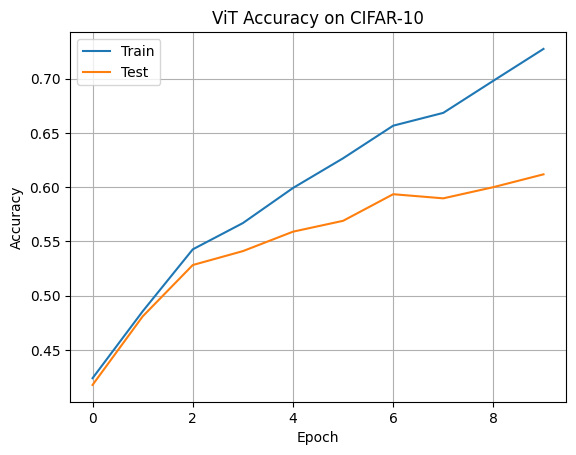

In [10]:
# 📈 Plot accuracy
plt.plot(train_accs, label="Train")
plt.plot(test_accs, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ViT Accuracy on CIFAR-10")
plt.legend()
plt.grid()
plt.show()